# L3T20 - Capstone Project 3

## Setup

This is where package import and variable initialisation is performed in preparation for the requirements of the project.

In [1]:
# Import required packages for project

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import LSTM
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [2]:
# Model configuration

rev_length = 500
t_words = 10000
embed_dim = 15
loss_f = 'binary_crossentropy'
optimizer = 'adam'
metrics = ['accuracy']
epochs = 3
verbosity_mode = True
bat_size = 64


## Get the Dataset

In this section the data is imported and visualised in order to understand what the data is communicating.

In [3]:
# Load dataset  and key from imdb set

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words = t_words)
word_to_id = imdb.get_word_index()


In [4]:
# Create key for review generation

offset=3   # word index offset
word_to_id = {k:(v + offset) for k, v in word_to_id.items()}
word_to_id["<PAD>"] = 0
word_to_id["<START>"] = 1
word_to_id["<UNK>"] = 2
word_to_id["<UNUSED>"] = 3
id_to_word = {value:key for key, value in word_to_id.items()}

# Define review print function

def print_rev(rev):
    print('\n=================================================')
    print(f'Sample = {i} | Length = {len(rev)}')
    print('=================================================')
    print(' '.join(id_to_word[id] for id in rev ))
    


In [5]:
 # Print random reviews
    
rev_n = 3
for i in np.random.randint(0, len(x_train), rev_n):
    print_rev(x_train[i])
    


Sample = 5326 | Length = 116
<START> i realize this review will get me <UNK> by the expert film critics <UNK> this site but i will defend this film br br the dentist is actually a really good film the acting isn't always top notch but the thrills are good and the story's good plus you see linda <UNK> <UNK> not that i'm an expert in this field but the direction seems good and the plot makes sense corbin makes a great creepy dentist it does to <UNK> what jaws does to sharks ish it obviously had a fairly limited budget but they did well with it what they could and developed the characters well those that count br br the end

Sample = 100 | Length = 158
<START> i am a great fan of david lynch and have everything that he's made on dvd except for hotel room the 2 hour twin peaks movie so when i found out about this i immediately grabbed it and and what is this it's a bunch of <UNK> drawn black and white cartoons that are loud and foul mouthed and unfunny maybe i don't know what's good but m

## Preprocessing

The data is then preprocessed in order to ensure compatibility with the modelling structures to be used in the neural network. The only processing required is that the reviews need to be truncated to 500 words and any reviews shorter are to be padded so that all of the data is of a similar size.

In [6]:
# Pad review sequences

x_trainp = pad_sequences(x_train, maxlen = rev_length, value = 0)
x_testp = pad_sequences(x_test, maxlen = rev_length, value = 0)


## Model Building

The Neural Network is now developed. The first layer is the Embedding layer which allows the neural network to operate on text data that are converted to integers. LSTM layers are then added to enable the recurrence required in the RNN. Dropout wa used in order to help prevent overfitting of the model.

The input to the model would be a vector of 500 integers as defined in the data preprocessing step while the output would be a number between 0 and 1 where 0 is a negative sentiment and 1 is a postive sentiment.

In [7]:
# Define the nearal model layers
np.random.seed(7)
model = Sequential()
model.add(Embedding(t_words, embed_dim, input_length = rev_length))
#model.add(Dropout(0.50))
model.add(LSTM(64, return_sequences = True))
model.add(LSTM(32))
#model.add(Dropout(0.20))
model.add(Dense(1, activation = 'sigmoid'))


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


## Model Training

The model is then compiled and trained using the training and test sets.

In [8]:
# Compile the model
model.compile(optimizer = optimizer, loss = loss_f, metrics = metrics)

# Give a summary
model.summary()

# Train the model
epochist = model.fit(x_trainp, y_train, epochs = epochs
                     , verbose = verbosity_mode
                     , validation_data = (x_testp, y_test)
                     , batch_size = bat_size)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 500, 15)           150000    
_________________________________________________________________
lstm (LSTM)                  (None, 500, 64)           20480     
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 182,929
Trainable params: 182,929
Non-trainable params: 0
_________________________________________________________________
Train on 25000 samples, validate on 25000 samples
Epoch 1/3
25000/25000 [==============================] - 378s 15ms/sample - loss: 0.4708 - acc: 0.7706 -

## Model Testing

The performance of the neural network is then evaluated using the test set and the epoch history is visualised to see whether further epochs may improve the model significantly.

In [9]:
# Evaluate model performance using test data

test_results = model.evaluate(x_testp, y_test, verbose = False)
print(f'Test results: \n ==> Loss: {np.round(test_results[0], 3)}\
    \n ==> Accuracy: {np.round(100*test_results[1], 2)}%')


Test results: 
 ==> Loss: 0.404    
 ==> Accuracy: 84.77%


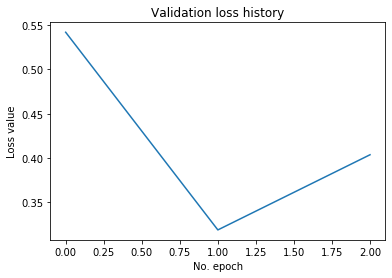

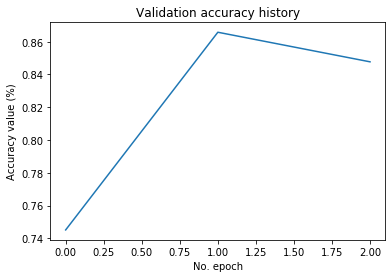

In [10]:
# Visualize history
# Plot history: Validation loss
plt.plot(epochist.history['val_loss'])
plt.title('Validation loss history')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.show()

# Plot history: Accuracy
plt.plot(epochist.history['val_acc'])
plt.title('Validation accuracy history')
plt.ylabel('Accuracy value (%)')
plt.xlabel('No. epoch')
plt.show()


## Prediction examples

The final test of the model is whether it can identify a handful of sentiments from some sample reviews. An evaluation function is defined that takes a string (review) and converts it to a list of integers which can then be processes into inputs to the model. The output of the function will indicate the sentiment of the review.

In [34]:
# Define function that outputs the sentiment from 
# a review using the neural network

def evaluate(review):
    # Split review into words
    r_split = review.lower().split()
    
    # Convert words to integers using word_to_id dictionary
    r_id = [2 if word_to_id.get(m) == None 
            else word_to_id.get(m) for m in r_split]
    
    # Pad and truncate to input length
    rid_p = pad_sequences(np.array(list([r_id])), 
                      maxlen = rev_length, value = 0)
    
    # Use model
    sent = model.predict(rid_p)
    
    # Interpret results
    if sent < 0.95:
        sentiment = 'Negative'
    else:
        sentiment = 'Positive'
    return sentiment


In [36]:
# Test model with self-defined examples

examples = ['This movie is good'
            ,'This movie is not good'
            ,'This movie was good'
            ,'This movie was not good'
            , 'This movie is bad'
            , 'This movie is not bad'
            , 'This movie was bad'
            , 'This movie was not bad'
            , 'An interesting study in death by boredom'
            , 'Fascinating and beautiful'
            , 'The movie is great'
            , 'The movie is not great'
]

for eg in examples:
    print(f'{eg} --> {evaluate(eg)} Sentiment')
    

This movie is good --> Positive Sentiment
This movie is not good --> Negative Sentiment
This movie was good --> Positive Sentiment
This movie was not good --> Negative Sentiment
This movie is bad --> Negative Sentiment
This movie is not bad --> Negative Sentiment
This movie was bad --> Negative Sentiment
This movie was not bad --> Negative Sentiment
An interesting study in death by boredom --> Negative Sentiment
Fascinating and beautiful --> Positive Sentiment
The movie is great --> Positive Sentiment
The movie is not great --> Positive Sentiment


Various reviews were passed through the model. Short examples were used as short reviews are more difficult to evaluate due to lower amounts of data and this will allow the identification of weak points in the neural network.

The main issue with the prediction of the model is that negatives are not handled consistently 'not good' is correctly identified as negative however 'not bad' is not identified as positive and 'not great' is not identified as negative.